## MAC0460 - Projeto
Members:

* Luã Nowacki Scavacini Santilli - NUSP 11795492

* João Vitor Magalhães Leite - NUSP 11849414

### Summary
To simplify some processes, we decided to use the open-source library PyTorch, which has useful tools for deep learning. Cifar-10 data can be downloaded through the library datasets module.

In possession of the dataset, initial procedures were performed. First, converting the format of the images through the transforms module included in the library, and then the normalization of the converted images. Finally, the baseline of the first model was established, reaching an accuracy close to 40% on the validation data.

More specific details and the implementation of these processes can be found in the appropriate sections throughout the notebook.


### Importing libraries

We will be using the PyTorch library. 

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

torch.set_printoptions(edgeitems=2)
torch.manual_seed(420)

### Getting the dataset

For getting the CIFAR10 dataset we can use the built-in module
datasets.CIFAR10. The next few cells download the data
if it's not already present. 

In [2]:
from torchvision import datasets, transforms

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
from torchvision import datasets
data_path = '/data/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x2BDE62DE820>, 1, 'automobile')

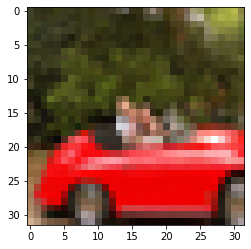

In [6]:
# Sample image
plt.imshow(img)
plt.show()

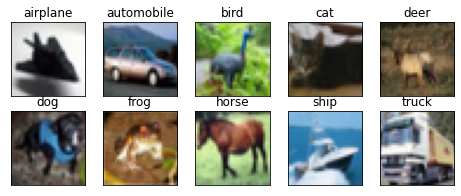

In [7]:
fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

### Converting the images to a desired format

The images we get from the Dataset are in the format Height X Width X Channels. 
This is common format, and the one used for matplotlib to display images. 
But, for perfomance reasons, we want the images in the format Channels X Height X Width. 
This can be accomplished with the built-in module transforms.

In [8]:
from torchvision import transforms

In [9]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor())

In [10]:
img_t, label = tensor_cifar10[99]
img_t, label

(tensor([[[0.2431, 0.1961,  ..., 0.7176, 0.5373],
          [0.2471, 0.2157,  ..., 0.6706, 0.5686],
          ...,
          [0.7176, 0.5882,  ..., 0.5294, 0.5608],
          [0.8196, 0.7137,  ..., 0.5098, 0.6627]],
 
         [[0.2510, 0.1961,  ..., 0.7216, 0.5333],
          [0.2549, 0.2078,  ..., 0.6824, 0.5725],
          ...,
          [0.5725, 0.4627,  ..., 0.4627, 0.4902],
          [0.6824, 0.5922,  ..., 0.4667, 0.6118]],
 
         [[0.1725, 0.1020,  ..., 0.2980, 0.2824],
          [0.1451, 0.1020,  ..., 0.2941, 0.3020],
          ...,
          [0.4588, 0.3725,  ..., 0.3843, 0.4314],
          [0.5647, 0.4824,  ..., 0.4353, 0.6275]]]),
 1)

In [11]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

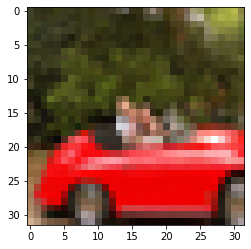

In [12]:
# If we want to see this image we can use the permute method
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

### Normalizing the images

It's standard practice to normalize the images on the dataset to 0,
given the caracteristics of the activation functions. Namely, their 
behavior around the range [-1, +1]. For PyTorch,
this means that we need  to find the mean and the standard deviation across
the whole set of images. And them normalize them given the new values. 

For this purpose we are going to built a 3 x 32 x 32 x 50000 tensor.
Such that when we average across the last 3 dimensions, we get the 
mean value for each color channel across the dataset. The same can 
be said for the standard deviation.

In [13]:
# imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
# imgs.shape

# -> torch.Size([3, 32, 32, 50000])

In [14]:
# imgs.view(3, -1).mean(dim=1)

# -> tensor([0.4914, 0.4822, 0.4465])

In [15]:
# imgs.view(3, -1).std(dim=1)

# -> tensor([0.2470, 0.2435, 0.2616])

Now that we have found the mean and std for the whole training dataset. 
We can load the images and apply these transformations.

In [17]:
# Freeing some unused memory. Will trow an error if they are not allocated.
# del imgs
# del tensor_cifar10

In [18]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [19]:
cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


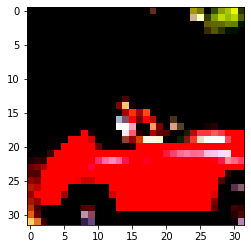

In [20]:
img_t, _ = cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

# Partitioning the data

The CIFAR10 dataset is already divided into training data and test data. The training data consists of 50000 images, while the test
data, of 10000 images. Given the data utilization policy, namely the use of the test data after the definition of a final model, 
we will split the training data into a proper training set and a validation set. And use the test set only after choosing the final model.

The training set will be used to find the parameters of the model, and the validation set to find the hyper-parameters of the model, such 
as the learning rate.

In [21]:
train_set, val_set = torch.utils.data.random_split(cifar10, [40000, 10000])
len(train_set)

40000

In [22]:
test_set = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [23]:
test_set

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))
           )

# Baseline

### Establishing a baseline with a simple fully connected network

In [24]:
import torch.nn as nn
import torch.optim as optim

n_out = 10

# Setting the network arquitecture
model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 50),
            nn.Tanh(),
            nn.Linear(50, n_out),
            nn.LogSoftmax(dim=1))

# Setting the optimizer algorithm
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Setting the loss function
loss_fn = nn.NLLLoss()

In [25]:
# Example of applying the model
img_tensor, label = train_set[23]
res = model(img_tensor.view(-1).unsqueeze(0))
res

tensor([[-2.4394, -1.7318, -2.3221, -2.8085, -2.4114, -2.2195, -2.3366, -2.5546,
         -2.4511, -2.1326]], grad_fn=<LogSoftmaxBackward0>)

In [26]:
# The exponent of the values should sum to 1
eps = 0.0001
assert torch.exp(res).sum() > 1.0 - eps
assert torch.exp(res).sum() < 1.0 + eps

In [27]:
# Example usage of loss function
out = model(img_tensor.view(-1).unsqueeze(0))
loss = loss_fn(out, torch.tensor([label]))
loss

tensor(2.4394, grad_fn=<NllLossBackward0>)

In [28]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64,
                                           shuffle=False)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                           shuffle=True)

In [29]:
def calc_acc(model, loader):
    correct = 0
    total = 0
    for imgs, labels in loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
    return (correct/total)

In [140]:
%%time
val_acc = calc_acc(model, train_loader)
print("Accuracy: %f" % val_acc)

Accuracy: 0.088325
CPU times: total: 44.2 s
Wall time: 7.54 s


In [141]:
%%time
val_acc = calc_acc(model, val_loader)
print("Accuracy: %f" % val_acc)

Accuracy: 0.093700
CPU times: total: 9.94 s
Wall time: 1.66 s


In [82]:
# Setting the number of epochs
n_epochs = 15

In [83]:
def training_loop(model, n_epochs, optimizer, loss_fn, 
                  train_loader, val_loader,
                  training_loss_hist, training_acc_hist, val_acc_hist):
    for epoch in range(n_epochs):
        running_loss = 0.0
        for img, label in train_loader:
            out = model(img)
            loss = loss_fn(out, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss/(len(train_loader))

        train_acc = calc_acc(model, train_loader)
        val_acc = calc_acc(model, val_loader)
        
        training_loss_hist.append(epoch_loss)
        training_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        print("Epoch: %d, Loss: %f, Train Acc: %f, Val Acc: %f" % (epoch, epoch_loss, train_acc, val_acc))

In [84]:
%%time
training_loss_hist = []
training_acc_hist = []
val_acc_hist = []

training_loop(model=model, 
              n_epochs=n_epochs, 
              optimizer=optimizer, 
              loss_fn=loss_fn, 
              train_loader=train_loader,
              val_loader=val_loader,
              training_loss_hist=training_loss_hist, 
              training_acc_hist=training_acc_hist, 
              val_acc_hist=val_acc_hist)
# Epoch: 0, Loss: 1.835980, Train Acc: 0.386250, Val Acc: 0.364200
# Epoch: 1, Loss: 1.748024, Train Acc: 0.410425, Val Acc: 0.385600
# Epoch: 2, Loss: 1.709024, Train Acc: 0.420550, Val Acc: 0.393400
# Epoch: 3, Loss: 1.684310, Train Acc: 0.426700, Val Acc: 0.400700
# Epoch: 4, Loss: 1.664568, Train Acc: 0.428875, Val Acc: 0.394900
# Epoch: 5, Loss: 1.649587, Train Acc: 0.438250, Val Acc: 0.396100
# Epoch: 6, Loss: 1.634953, Train Acc: 0.441975, Val Acc: 0.397000
# Epoch: 7, Loss: 1.627033, Train Acc: 0.449275, Val Acc: 0.406400
# Epoch: 8, Loss: 1.618058, Train Acc: 0.445750, Val Acc: 0.404200
# Epoch: 9, Loss: 1.613889, Train Acc: 0.447600, Val Acc: 0.396600
# Epoch: 10, Loss: 1.602639, Train Acc: 0.453925, Val Acc: 0.404500
# Epoch: 11, Loss: 1.588301, Train Acc: 0.457725, Val Acc: 0.402400
# Epoch: 12, Loss: 1.586442, Train Acc: 0.454450, Val Acc: 0.408700
# Epoch: 13, Loss: 1.580275, Train Acc: 0.465375, Val Acc: 0.415600
# Epoch: 14, Loss: 1.573952, Train Acc: 0.464750, Val Acc: 0.409100
# CPU times: total: 22min 54s
# Wall time: 3min 49s

Epoch: 0, Loss: 1.847246, Train Acc: 0.396825, Val Acc: 0.379600
Epoch: 1, Loss: 1.758970, Train Acc: 0.400950, Val Acc: 0.375800
Epoch: 2, Loss: 1.726032, Train Acc: 0.412050, Val Acc: 0.389800
Epoch: 3, Loss: 1.699031, Train Acc: 0.424400, Val Acc: 0.392600
Epoch: 4, Loss: 1.682398, Train Acc: 0.429425, Val Acc: 0.401200
Epoch: 5, Loss: 1.667397, Train Acc: 0.433225, Val Acc: 0.399400
Epoch: 6, Loss: 1.651347, Train Acc: 0.436575, Val Acc: 0.399000
Epoch: 7, Loss: 1.640903, Train Acc: 0.439125, Val Acc: 0.405000
Epoch: 8, Loss: 1.626550, Train Acc: 0.443750, Val Acc: 0.402600
Epoch: 9, Loss: 1.618947, Train Acc: 0.448850, Val Acc: 0.408600
Epoch: 10, Loss: 1.611144, Train Acc: 0.449250, Val Acc: 0.407000
Epoch: 11, Loss: 1.606807, Train Acc: 0.451875, Val Acc: 0.415700
Epoch: 12, Loss: 1.594326, Train Acc: 0.461050, Val Acc: 0.414800
Epoch: 13, Loss: 1.583565, Train Acc: 0.463275, Val Acc: 0.415000
Epoch: 14, Loss: 1.578648, Train Acc: 0.464700, Val Acc: 0.410300
CPU times: total: 22

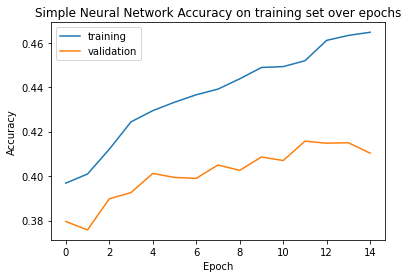

In [142]:
plt.plot(training_acc_hist, label='training')
plt.plot(val_acc_hist, label='validation')
plt.title('Simple Neural Network Accuracy on training set over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

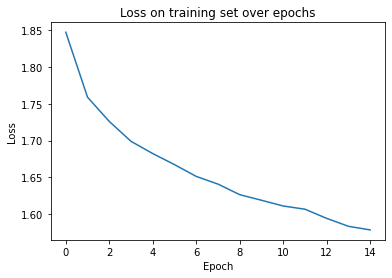

In [143]:
plt.plot(training_loss_hist)
plt.title('Loss on training set over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

As we can see by the graphs, there is an increasing distance between the accuracy on the training and the validation. This indicates that the model is overleaning on the training data. 
Therefore, even though we can decrease the loss and increase the accuracy on the training data, this learning will probably not generalize. 
This way we can estabilsh the baseline at around 40% on the validation data. This will be our base to further exploration.

# Exploration

Using LeNet

In [146]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [147]:
# Setting the network arquitecture
lenet_model = LeNet()

# Setting the optimizer algorithm
lenet_learning_rate = 1e-3
lenet_optimizer = optim.Adam(lenet_model.parameters(), lr=lenet_learning_rate)

# Setting the loss function
lenet_loss_fn = nn.CrossEntropyLoss()

# Setting the number of epochs
lenet_epochs = 10

In [149]:
# %%time
# lenet_training_loss_hist = []
# lenet_training_acc_hist = []
# lenet_val_acc_hist = []

# training_loop(model=lenet_model, 
#               n_epochs=lenet_epochs, 
#               optimizer=lenet_optimizer, 
#               loss_fn=lenet_loss_fn, 
#               train_loader=train_loader,
#               val_loader=val_loader,
#               training_loss_hist=lenet_training_loss_hist, 
#               training_acc_hist=lenet_training_acc_hist, 
#               val_acc_hist=lenet_val_acc_hist)

# Epoch: 0, Loss: 1.543213, Train Acc: 0.546450, Val Acc: 0.536000
# Epoch: 1, Loss: 1.176323, Train Acc: 0.633825, Val Acc: 0.611300
# Epoch: 2, Loss: 1.007494, Train Acc: 0.669550, Val Acc: 0.641900
# Epoch: 3, Loss: 0.899880, Train Acc: 0.711375, Val Acc: 0.672200
# Epoch: 4, Loss: 0.815342, Train Acc: 0.743775, Val Acc: 0.692000
# Epoch: 5, Loss: 0.744732, Train Acc: 0.766675, Val Acc: 0.699600
# Epoch: 6, Loss: 0.675443, Train Acc: 0.792350, Val Acc: 0.703000
# Epoch: 7, Loss: 0.626410, Train Acc: 0.794600, Val Acc: 0.695800
# Epoch: 8, Loss: 0.582302, Train Acc: 0.818550, Val Acc: 0.704900
# Epoch: 9, Loss: 0.536572, Train Acc: 0.842325, Val Acc: 0.713700
# CPU times: total: 37min 34s
# Wall time: 6min 15s

In [157]:
# torch.save(lenet_model.state_dict(), 'model/lenet.pth')

In [162]:
lenet_model.load_state_dict(torch.load('model/lenet.pth'))
lenet_model.eval()

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [163]:
%%time
val_acc = calc_acc(lenet_model, val_loader)
print("Accuracy: %f" % val_acc)

Accuracy: 0.745100
CPU times: total: 19 s
Wall time: 3.19 s


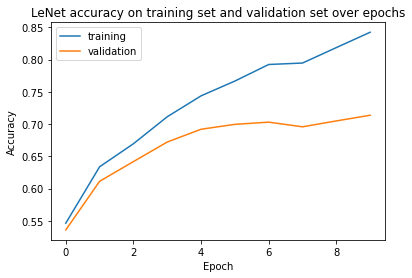

In [164]:
plt.plot(lenet_training_acc_hist, label='training')
plt.plot(lenet_val_acc_hist, label='validation')
plt.title('LeNet accuracy on training set and validation set over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

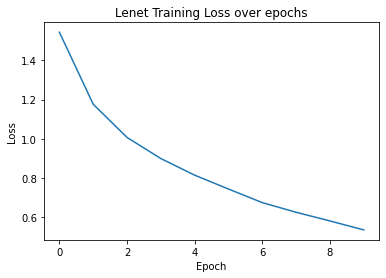

In [165]:
plt.plot(lenet_training_loss_hist)
plt.title('Lenet Training Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Using data augmentation

# Transfer Learning

Here we tried to use a pre-trained model of AlexNet. 
But the training turned out to be unfeasible in our current
computational setup. 

Each epoch was taking more
than 1 hour to run. And the perfomance over the validation 
set was not improving at the expected rate. 

Hence we decided to cut this section short. Even though 
this could have been the best perfoming model in the long run. 

In [94]:
from torchvision import models

In [100]:
# Setting the network arquitecture
alex_net_model = models.alexnet(weights=True)

In [101]:
alex_net_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [102]:
# Here we fix the features that will not be trained
for param in alex_net_model.features.parameters():
    param.requires_grad = False

In [108]:
# We also need to modify the final layer of the model. To output a 10-d vector instead of a 1000-d one.
n_inputs = alex_net_model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(class_names)) 
alex_net_model.classifier[6] = last_layer

In [109]:
alex_net_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Another important modification is to resize the images to fit the expected input.

Given that AlexNet was trained on the ImageNet dataset, we need to resize the images
to 224x224. This can be done in PyTorch through the creation of another dataset, 
by passing the trasnforms.Resize method.

In [110]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      # transforms.RandomHorizontalFlip(),
                                      # transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      # transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4915, 0.4823, 0.4468),
                                                           (0.2470, 0.2435, 0.2616))
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

alex_net_dataset = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transform_train
    )

train_set, val_set = torch.utils.data.random_split(alex_net_dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =64, shuffle=False)

In [111]:
for x, y in train_loader:
    break

In [115]:
# Setting the optimizer algorithm
alex_net_learning_rate = 1e-3
alex_net_optimizer = optim.Adam(alex_net_model.parameters(), lr=alex_net_learning_rate)

# Setting the loss function
alex_net_loss_fn = nn.CrossEntropyLoss()

# Setting the number of epochs
alex_net_epochs = 10

In [116]:
alex_net_model(x).shape

torch.Size([64, 10])

In [166]:
# %%time
# alex_net_training_loss_hist = []
# alex_net_training_acc_hist = []
# alex_net_val_acc_hist = []

# training_loop(model=alex_net_model, 
#               n_epochs=alex_net_epochs, 
#               optimizer=alex_net_optimizer, 
#               loss_fn=alex_net_loss_fn,
#               train_loader=train_loader,
#               val_loader=val_loader,
#               training_loss_hist=alex_net_training_loss_hist, 
#               training_acc_hist=alex_net_training_acc_hist, 
#               val_acc_hist=alex_net_val_acc_hist)
# Just this execution took more than 5 hours
# Epoch: 0, Loss: 1.865588, Train Acc: 0.428250, Val Acc: 0.420200
# Epoch: 1, Loss: 1.419102, Train Acc: 0.506050, Val Acc: 0.495500
# Epoch: 2, Loss: 1.219046, Train Acc: 0.603300, Val Acc: 0.583500
# Epoch: 3, Loss: 1.084034, Train Acc: 0.624775, Val Acc: 0.597900
# Epoch: 4, Loss: 0.989995, Train Acc: 0.677425, Val Acc: 0.644600
# Epoch: 5, Loss: 0.927115, Train Acc: 0.689050, Val Acc: 0.649500